## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [123]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


The provided data include user id, promotion (yes/no), purchase (1/0) and 7 unknown parameters(V1, V4, V5, V6 and V7 are categorical data; V2 and V3 are numeric).

## Data Exploration

The size of the provided data is given:

In [3]:
train_data.shape

(84534, 10)

The length of the dataset is 84534 

In [5]:
train_data.dropna(how='any').shape

(84534, 10)

The train_data does not include any missing value

In [8]:
train_data.drop_duplicates(subset=['ID']).shape

(84534, 10)

The train_data does not include any duplicates

In [187]:
promotion_count = train_data.groupby(['Promotion'])['ID'].count()
promotion_count

Promotion
No     42170
Yes    42364
Name: ID, dtype: int64

In [188]:
purchase_count = train_data.groupby(['purchase'])['ID'].count()
purchase_count

purchase
0    83494
1     1040
Name: ID, dtype: int64

In [189]:
promotion_and_purchase_count = train_data.groupby(['Promotion','purchase'])['ID'].count()
promotion_and_purchase_count

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: ID, dtype: int64

The number of the purchase for experiment group is indeed higher than the control group, but this could be caused by the randomness. The next step is to build up A/B test to test the statistical significance.

## Get IRR and NIR

This project chose IRR and NIR as the evaluation metrics. 
$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$
$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [190]:
purch_treat = promotion_and_purchase_count[3]
cust_treat = promotion_count[1]
purch_ctrl = promotion_and_purchase_count[1]
cust_ctrl = promotion_count[0]

IRR_obs = purch_treat/cust_treat - purch_ctrl/cust_ctrl
NIR_obs = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl
print('IRR:' + str(IRR_obs) )
print('NIR:' + str(NIR_obs) )

IRR:0.00945454781977
NIR:-2334.6


Although the IRR is positive, NIR is negative which indicates that the increased purchase cannot cover the cost. To further investigate this, the following section would conduct an AB test to evaluate the result.

## Invariant Metric - Number of promotion

### The analytic approach:

In [28]:
# get number of trials and number of controls
n_obs = train_data.shape[0]
n_control = promotion_count[0]

# compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

# check for significance
if 2 * sp.stats.norm.cdf(z) >= .05:
    print('Invariant metric does not differ significantly between control and treatment group.')
else:
    print('ATTENTION: Invariant metric differs significantly between control and treatment group.')
print('z-score = ' + str("{:.4f}".format(z)))
print('p-value = ' + str("{:.4f}".format(2 * sp.stats.norm.cdf(z))))

Invariant metric does not differ significantly between control and treatment group.
z-score = -0.6638
p-value = 0.5068


### Similation based approach:

In [20]:
# get number of trials and number of controls
n_obs = train_data.shape[0]
n_control = promotion_count[0]

p = 0.5
n_trials = 200_000
samples = np.random.binomial(n_obs, p, n_trials)
print('p-value = ' + str(np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean()))

p-value = 0.508


both p-value greater than 0.05 - the collection of the data was implemented in a correct way!

## Evaluation Metric - Purchases Rate

H0: IRR<=0; Ha: IRR>0

### Analytic Aproach

In [22]:
# get the purchase rate
p_purchase = train_data.groupby('Promotion').mean()['purchase']
print(p_purchase)

Promotion
No     0.007565
Yes    0.017019
Name: purchase, dtype: float64


In [26]:
# get number of trials and overall 'success' rate under null
n_ctrl = train_data.groupby('Promotion').size()[0]
n_treat = train_data.groupby('Promotion').size()[1]
p_null = train_data['purchase'].mean()

In [32]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_ctrl + 1/n_treat))

z = (p_purchase[1] - p_purchase[0]) / se_p

# check for significance
if 1-sp.stats.norm.cdf(z) >= .05:
    print('Evaluation metric does not differ significantly between control and treatment group.')
else:
    print('Evaluation metric differs significantly between control and treatment group.')
print('z-score = ' + str("{:.4f}".format(z)))
print('p-value = ' + str("{:.19f}".format(1-sp.stats.norm.cdf(z))))

Evaluation metric differs significantly between control and treatment group.
z-score = 12.4684
p-value = 0.0000000000000000000


### Simulation Approach

In [38]:
n_ctrl = train_data.groupby('Promotion').size()[0]
n_treat = train_data.groupby('Promotion').size()[1]
p_null = train_data['purchase'].mean()


n_trials = 200_000
ctrl_purchase = np.random.binomial(n_ctrl, p_null, n_trials)
treat_purchase = np.random.binomial(n_treat, p_null, n_trials)
samples = treat_purchase / n_treat - ctrl_purchase / n_ctrl

print('p-value = ' + str("{:.19f}".format((samples >= (p_purchase[1] - p_purchase[0])).mean())))

p-value = 0.0000000000000000000


Both approach validated that the purchase rate will be enchanced. 

## Non-Parameteric Test on IRR & NIR - Permutation Test

In [194]:
def permutation_test(df, label, n_trials = 10_000):
    """
    Compute the upper limit of confidence intervals (to test for metric increase) for IRR & NIR using Bonferroni correction.
    
    Input arguments:
        df: (dataframe) Data to be tested
        label: (string) Dimension that should be permuted
        permutations: (integer) Randomized permutation trials
    
    Output:
        irr_limit, nir_limit: Upper limits of confidence intervals for IRR & NIR after Bonferroni correction
    """
    
    irr_samples = []
    nir_samples = []
    
    for _ in range(n_trials):
        # random permutation of label
        df[label] = np.random.permutation(df[label])
        
        # prepare data
        promotion_count = df.groupby([label])['ID'].count()
        promotion_and_purchase_count = df.groupby([label,'purchase'])['ID'].count()
        
        purch_treat = promotion_and_purchase_count[3]
        cust_treat = promotion_count[1] 
        purch_ctrl = promotion_and_purchase_count[1]
        cust_ctrl = promotion_count[0]
        
        # mathematical representation of the metrics IRR & NIR
        irr_trial = purch_treat / cust_treat - purch_ctrl / cust_ctrl
        nir_trial = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl

        irr_samples.append(irr_trial)
        nir_samples.append(nir_trial)
    
    # one-sided confidence interval with Bonferroni correction:
    # overall significance level of 0.05, individual significance level of 0.025
    irr_limit = np.percentile(np.array(irr_samples),0.975)
    nir_limit = np.percentile(np.array(nir_samples),0.975)
    
    
    if IRR_obs > irr_limit:
        print('Incremental response rate (IRR) lies outside of upper confidence limit. It is a significant increment.')
    else:
        print('Incremental response rate (IRR) lies below upper confidence limit. It is not a significant increment.')
    if NIR_obs > nir_limit:
        print('Net incremental revenue (NIR) lies outside of upper confidence limit. It is a significant increment.')
    else: 
        print('Net incremental revenue (NIR) lies below upper confidence limit. It is not a significant increment.')
    
    return irr_limit, nir_limit

In [196]:
irr_limit, nir_limit = permutation_test(df=train_data.copy(), label='Promotion')

print('Upper confidence limit of IRR = {}. IRR in dataset = {}.'.format("{:.2f}".format(irr_limit), "{:.2f}".format(IRR_obs)))
print('Upper confidence limit of NIR = {}. NIR in dataset = {}.'.format("{:.2f}".format(nir_limit), "{:.2f}".format(NIR_obs)))

Incremental response rate (IRR) lies outside of upper confidence limit. It is a significant increment.
Net incremental revenue (NIR) lies outside of upper confidence limit. It is a significant increment.
Upper confidence limit of IRR = -0.00. IRR in dataset = 0.01.
Upper confidence limit of NIR = -7094.60. NIR in dataset = -2334.60.


## Promotion Strategy Optimization

The last sections have validated that the IRR is positive with promotion strategies (equivalently, the purchase rate is increased), but the NIR is negative (in the other words, profit is decreased). So, the existed promotion strategy is not acceptable for Starbucks even though it indeed increase the purchase rate. To improve NIR, an optimized promotion strategy can be used. The optimized promotion strategy can select the potential customers who is easily influenced by promotion to send promotion coupons. In this way, Starbucks can reduce the cost of the promotion and possibly make NIR positive. To achieve this, an automatic customer selection filter is required. This section would build up an intelligent classifier to filter customers and NIR will be used to test whether the classifier really work.

## feature exploration
Due to the physical meaning behind the feature are not provided, the statistical meaning need to be explore

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4143a85438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f41438505c0>]], dtype=object)

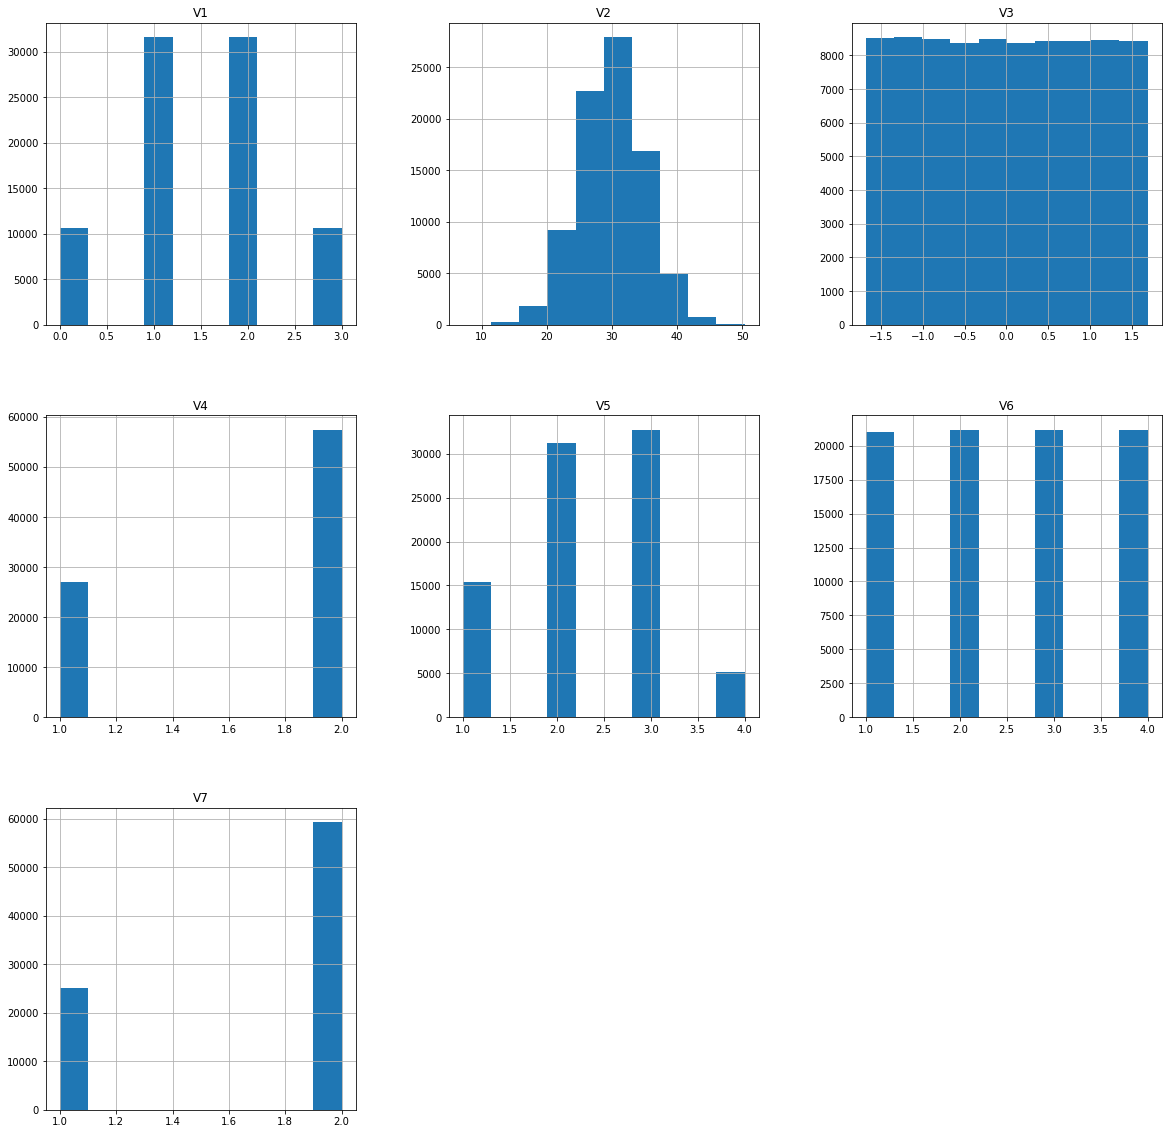

In [8]:
train_data[['V1','V2','V3','V4','V5','V6','V7']].hist(figsize = (20,20))

To further investigate the V3, the bins of histogram is sharply increased and the value count are used. 

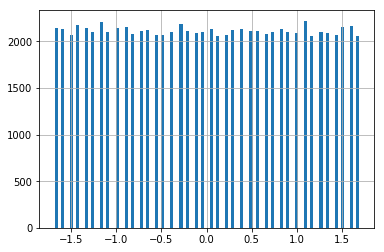

In [35]:
train_data['V3'].hist(bins=100)

In [46]:
sorted_V3_counts = train_data['V3'].value_counts().sort_index(ascending=False)
print('the number of V3: ' + str(sorted_V3_counts.shape[0]))
print('the range of V3 from ' + str(sorted_V3_counts.index.min()) + ' to ' + str(sorted_V3_counts.index.max()))

the number of V3: 40
the range of V3 from -1.6845501 to 1.6919836


In [42]:
gap=[]
for i in range(len(sorted_V3_counts)-1):
    gap.append(sorted_V3_counts.reset_index()['index'].loc[0]-sorted_V3_counts.reset_index()['index'].loc[1])
np.unique(gap)

array([ 0.08657779])

V1, V4, V5, V6, V7 are categorical data; V2 is a Gaussian distribution numeric data and V3 is a descrete numeric data with equivalent gap 

### Correlation Exploration

In [80]:
numerilised_train_data = train_data.copy()
numerilised_train_data ['Promotion'] = (numerilised_train_data['Promotion']=='Yes').astype(int)

In [82]:
numerilised_train_data[['V1','V2','V3','V4','V5','V6','V7','purchase','Promotion']].corr()

,V1,V2,V3,V4,V5,V6,V7,purchase,Promotion
V1,1.000000,-0.001564,0.003995,0.002568,-0.001196,-0.003672,0.001436,-0.004906,0.005039
V2,-0.001564,1.000000,0.001165,0.002848,-0.001046,-0.004156,-0.002293,-0.001694,-0.000652
V3,0.003995,0.001165,1.000000,0.003753,-0.001736,0.004464,0.001135,-0.006395,0.007269
V4,0.002568,0.002848,0.003753,1.000000,0.003161,0.002552,-0.003176,0.032245,-0.001416
V5,-0.001196,-0.001046,-0.001736,0.003161,1.000000,-0.003043,0.003571,0.007814,-0.003552
V6,-0.003672,-0.004156,0.004464,0.002552,-0.003043,1.000000,-0.001398,-0.001538,0.001190
V7,0.001436,-0.002293,0.001135,-0.003176,0.003571,-0.001398,1.000000,-0.001117,-0.001115
purchase,-0.004906,-0.001694,-0.006395,0.032245,0.007814,-0.001538,-0.001117,1.000000,0.042884
Promotion,0.005039,-0.000652,0.007269,-0.001416,-0.003552,0.001190,-0.001115,0.042884,1.000000


The features seem weakly correlated with each other, and V4 seems having largest correlation with purchase but it is still weak correlated. The old promotion strategy does not correlated to any of the features which is slighly correlated with purchase.

## data preprocess

In [173]:
def data_preprocess(df):
    # preprocess data including normalization, get_dummies()
    categorical_features = pd.get_dummies(data = df[['V1','V4','V5','V6','V7']],columns=['V1','V4','V5','V6','V7'])
    normalised_numeric_features = pd.DataFrame(preprocessing.normalize(df[['V2','V3']]), columns=['V2','V3'])
    processed_df = pd.concat([normalised_numeric_features, categorical_features],axis=1)
    
    return processed_df


def undersampling(processed_df,labels):
    processed_df = pd.concat([processed_df, labels],axis=1)
    # undersampling the data - the non-purchase people is significantly larger than purchase group
    count_0, count_1 = processed_df['purchase'].value_counts()
    # divide by class
    df_0 = processed_df[processed_df['purchase']==0]
    df_1 = processed_df[processed_df['purchase']==1]

    df_0_under = df_0.sample(count_1, random_state=42)
    df_under = pd.concat([df_0_under, df_1], axis=0)
    
    features_under = df_under.drop(['purchase'], axis=1)
    labels_under = df_under['purchase']
    
    return features_under, labels_under

def training():
    features = train_data.drop(['ID','Promotion','purchase'], axis=1)
    labels = train_data['purchase']
    
    processed_df = data_preprocess(features) 
    X,y = undersampling(processed_df,labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # initialize classifier
    clf = GradientBoostingClassifier(random_state=42)

    # fit classifier
    model = clf.fit(X_train, y_train)

    # evaluate classifier
    accuracy = model.score(X_test,y_test)
    print('Accuracy = ' + str("{:.2f}".format(accuracy*100)) + '%')
    return model

In [178]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    model = training()
    promotion = pd.Series(model.predict(data_preprocess(df))).map({0:'No', 1:'Yes'}).values
    
    return promotion

In [179]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Accuracy = 56.48%
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0174.

Your nir with this strategy is 217.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017375634577496687, 217.70000000000005)

The optimized strategy pass both IRR and NIR which could be a reasonable method to implement!